# Recherche et identification d'outliers

On parle d'outliers au sens de la lisibilité des images, soit en termes de niveau de luminosité, soit en termes de contraste.

In [171]:
import os
import pandas as pd
import numpy as np
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [207]:
from outlier_identification import contrast_img_indicators, get_all_masks_size, get_black_proportion_in_img, color_concentration, outliers_id

In [3]:
# Liens vers les données

data_folder = "../../data"
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
img_folder = "images"
lst_dirs_condition = [os.path.join(data_folder, cond, "images") for cond in conditions]
list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Lung Opacity", "Covid", "Normal"],
                                "img_dir" : lst_dirs_condition})

In [112]:
# Calcul pour chaque images d'indicateurs de lisibilté
contrast_df = contrast_img_indicators(0.05)


In [252]:
# Fusion des métadonnées avec les indicateurs de contraste calculés
data_meta = pd.read_csv(os.path.join(data_folder, "aggregated_metadata.csv"), index_col=0).drop(columns=["format", "resolution"])
data_meta['name_lower'] = data_meta['file_name'].str.lower()
contrast_df['name_lower'] = contrast_df['file_name'].str.lower()
contrast_img_data = contrast_df.merge(data_meta.drop(columns="file_name"), 
                                    on = str.lower("name_lower")).drop(columns="name_lower")

## Luminosité
### Niveaux moyens de luminosité

In [164]:
seuils_outliers_mean = np.quantile(contrast_img_data.color_mean, q=(0.025))
low_color_level = contrast_img_data[(contrast_img_data.color_mean<seuils_outliers_mean)]

print(low_color_level.data_type.value_counts())

condition = 'Covid'
dir_images = list_dir_images.img_dir[list_dir_images.img_type==condition].values[0]
filenames = low_color_level[low_color_level.data_type==condition].file_name + '.png'
files_size = len(filenames)
covid_out = []
for i, filename in enumerate(filenames):
    covid_out.append(cv2.imread(os.path.join(dir_images, filename)))

data_type
Lung Opacity       190
Normal             145
Covid              142
Viral Pneumonia     53
Name: count, dtype: int64


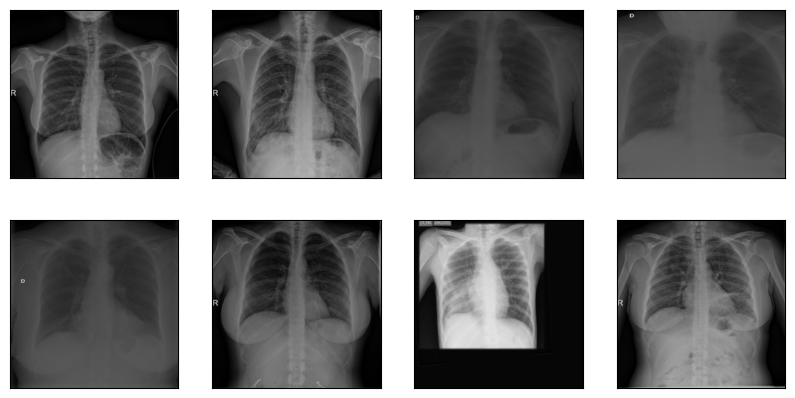

In [168]:
n_im = 8
ind_img = random.sample(list(np.arange(0,files_size)), n_im)
fig = plt.figure(figsize=(10, 10))

for i in range(round(n_im/2)) :
 ax = fig.add_subplot(1, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i]], cmap='gray')
 plt.xticks([])
 plt.yticks([])
 ax = fig.add_subplot(2, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i+round(n_im/2)]], cmap='gray')
 plt.xticks([])
 plt.yticks([])

### Proportion de pixels noirs dans les images

La part de pixels noirs dans l'image permet d'évaluer la proportion d'images encadrées d'un large cadre noir.

In [169]:
df_prop_black_img = get_black_proportion_in_img()

<Axes: xlabel='label', ylabel='black_prop'>

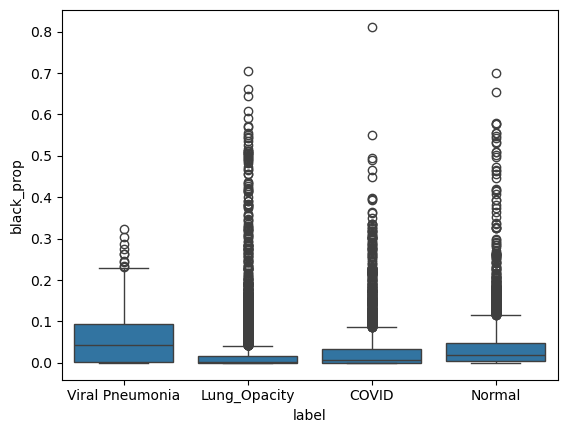

In [177]:
sns.boxplot(data = df_prop_black_img, y='black_prop', x='label')

In [196]:
np.quantile(df_prop_black_img.black_prop, 0.99)

0.2503144260131335

In [198]:
# Illustration pour un seuil à 40% de noir :
prop = 0.25
print("seuil à", 100*prop,"% de noir correspondant au quantile d'ordre", round(100*np.mean(df_prop_black_img.black_prop<prop),2),"%")

sus_frame = df_prop_black_img[(df_prop_black_img.black_prop>prop)]

print(sus_frame.label.value_counts(normalize=True))

cdt = 'Lung_Opacity'
dir_images = os.path.join(data_folder, cdt, "images")
filenames = sus_frame[sus_frame.label==cdt].file_name
files_size = len(filenames)
framed_imgs = []
for i, filename in enumerate(filenames):
    framed_imgs.append(cv2.imread(os.path.join(dir_images, filename)))

seuil à 25.0 % de noir correspondant au quantile d'ordre 99.0 %
label
Lung_Opacity       0.457547
Normal             0.268868
COVID              0.245283
Viral Pneumonia    0.028302
Name: proportion, dtype: float64


45% des images étant à plus de 25% constituées de pixels noirs appartiennent à la classe lung_opacity.

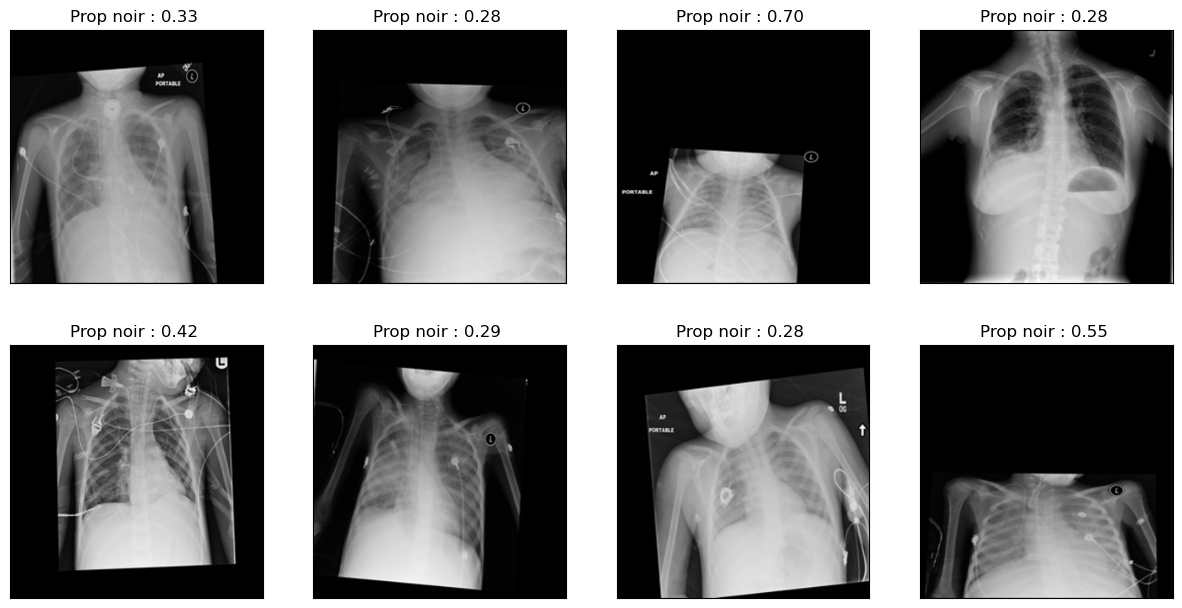

In [199]:
# Affichage de 8 images parmi les plus noires dans la classe lung_opacity

n_im = np.min([8, files_size])
ind_img = random.sample(list(np.arange(0,files_size)), n_im)
fig = plt.figure(figsize=(15, 15))

for i in range(round(n_im/2)) :
 propb = np.mean(framed_imgs[ind_img[i]]==0)
 ax = fig.add_subplot(1, round(n_im/2), i+1)
 ax.imshow(framed_imgs[ind_img[i]], cmap='gray')
 ax.set_title("Prop noir : %.2f "%(propb))
 plt.xticks([])
 plt.yticks([])

 ax = fig.add_subplot(2, round(n_im/2), i+1)
 propb_1 = np.mean(framed_imgs[ind_img[i+round(n_im/2)]]==0)
 ax.imshow(framed_imgs[ind_img[i+round(n_im/2)]], cmap='gray')
 ax.set_title("Prop noir : %.2f "%(propb_1))
 plt.xticks([])
 plt.yticks([])


### Taille des poumons

In [200]:
mean_lungs_size = get_all_masks_size()

<Axes: xlabel='label', ylabel='lung_portion'>

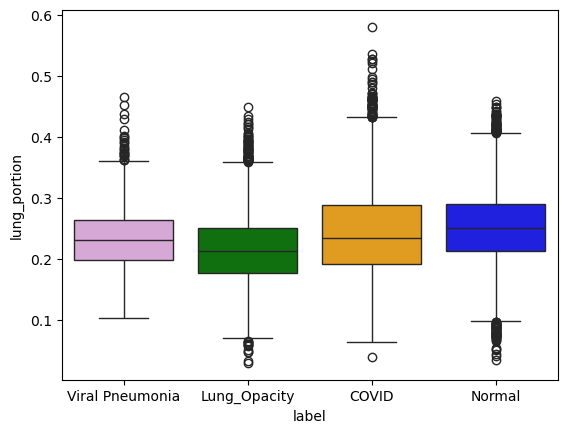

In [201]:
sns.boxplot(data = mean_lungs_size, y='lung_portion', x='label', hue = 'label',
            palette=['plum', 'g', 'orange', 'b'])

In [202]:
prop = 0.05
small_surface = mean_lungs_size[(mean_lungs_size.lung_portion<prop)]

print(small_surface.label.value_counts())

cdt = 'Lung_Opacity'
dir_images = os.path.join(data_folder, cdt, "images")
filenames = small_surface[small_surface.label==cdt].file_name
files_size = len(filenames)
cdt_small = []
for i, filename in enumerate(filenames):
    cdt_small.append(cv2.imread(os.path.join(dir_images, filename)))

label
Lung_Opacity    4
Normal          3
COVID           1
Name: count, dtype: int64


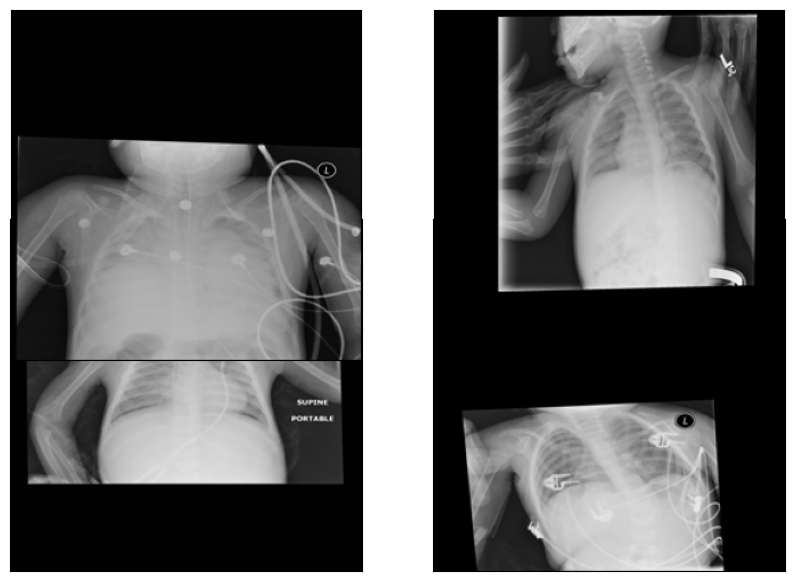

In [205]:
n_im = np.min([8, files_size])
ind_img = random.sample(list(np.arange(0,files_size)), n_im)
fig = plt.figure(figsize=(10, 10))

for i in range(round(n_im/2)) :
 ctst = np.mean(cdt_small[ind_img[i]]!=255)
 ax = fig.add_subplot(1, round(n_im/2), i+1)
 ax.imshow(cdt_small[ind_img[i]], cmap='gray')
 plt.xticks([])
 plt.yticks([])
 ax = fig.add_subplot(2, round(n_im/2), i+1)
 ctst_1 = np.mean(cdt_small[ind_img[i+round(n_im/2)]]!=255)
 ax.imshow(cdt_small[ind_img[i+round(n_im/2)]], cmap='gray')
 plt.xticks([])
 plt.yticks([])


# Niveau de contraste

In [208]:
low_contrast_images = outliers_id(level=0.005)

In [221]:
contrast_img_data.file_name+'.png'

0             COVID-1.png
1             COVID-2.png
2             COVID-3.png
3             COVID-4.png
4             COVID-5.png
               ...       
21160    NORMAL-10188.png
21161    NORMAL-10189.png
21162    NORMAL-10190.png
21163    NORMAL-10191.png
21164    NORMAL-10192.png
Name: file_name, Length: 21165, dtype: object

In [235]:
low_contrast_images.apply(lambda x: x.split('.')[0])

668      Viral Pneumonia-39
7454             COVID-1086
7517             COVID-1142
7557             COVID-1179
7699             COVID-1306
                ...        
10625             COVID-686
10637             COVID-697
10638             COVID-698
12630           Normal-2316
19594           Normal-8585
Name: file_name, Length: 106, dtype: object

In [243]:
contrast_img_data[contrast_img_data.file_name=="Normal_2316"]

,file_name,url,data_type,color_mean,color_std,color_concentration


In [237]:
np.sum(contrast_img_data.file_name.isin(low_contrast_images.apply(lambda x: x.split('.')[0])))

104

In [254]:
low_contrast = contrast_img_data[contrast_img_data.file_name.isin(low_contrast_images.apply(lambda x: x.split('.')[0]))]
low_contrast.data_type.value_counts()

data_type
Covid              103
Normal               2
Viral Pneumonia      1
Name: count, dtype: int64

In [255]:
cdt = 'Covid'
dir_images = os.path.join(data_folder, cdt, "images")
filenames = low_contrast_images
files_size = len(filenames)
covid_out = []
for i, filename in enumerate(filenames):
    covid_out.append(cv2.imread(os.path.join(dir_images, filename)))

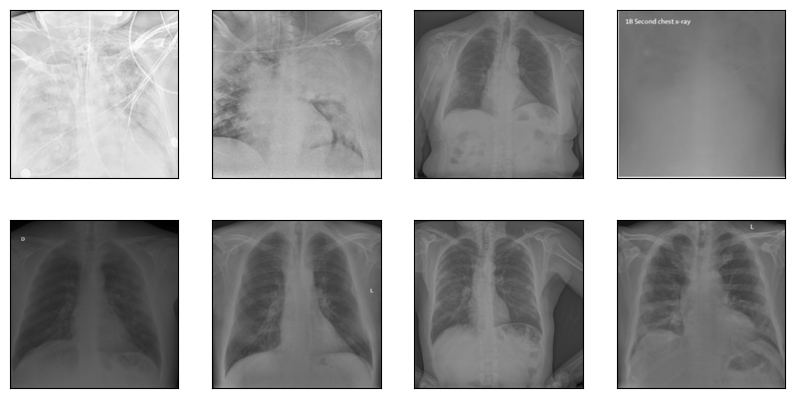

In [262]:
n_im = 8
ind_img = random.sample(list(np.arange(0,files_size)), n_im)
fig = plt.figure(figsize=(10, 10))

for i in range(round(n_im/2)) :
 ax = fig.add_subplot(1, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i]], cmap='gray')
 plt.xticks([])
 plt.yticks([])
 ax = fig.add_subplot(2, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i+round(n_im/2)]], cmap='gray')
 plt.xticks([])
 plt.yticks([])